# Key takeaways
- understanidng of difference between `os` and `pathlib`
- `tf.keras.utils.image_dataset_from_directory()` method makes a dataset from directory names
- `train_ds.take(1)` will return a tensor with shape (**batch_size**, width, height, channel)
- when being trained, `dataset` should be used with `buffered prefeching` so as to prevetn I/O blocking

##### Copyright 2020 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.


# Load and preprocess images

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/load_data/images"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/load_data/images.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/load_data/images.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/load_data/images.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This tutorial shows how to load and preprocess an image dataset in three ways:

- First, you will use high-level Keras preprocessing utilities (such as `tf.keras.utils.image_dataset_from_directory`) and layers (such as `tf.keras.layers.Rescaling`) to read a directory of images on disk.
- Next, you will write your own input pipeline from scratch [using tf.data](../../guide/data.ipynb).
- Finally, you will download a dataset from the large [catalog](https://www.tensorflow.org/datasets/catalog/overview) available in [TensorFlow Datasets](https://www.tensorflow.org/datasets).

## Setup

In [1]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds

In [2]:
print(tf.__version__)

2.8.0


### Download the flowers dataset

This tutorial uses a dataset of several thousand photos of flowers. The flowers dataset contains five sub-directories, one per class:

```
flowers_photos/
  daisy/
  dandelion/
  roses/
  sunflowers/
  tulips/
```

Note: all images are licensed CC-BY, creators are listed in the LICENSE.txt file.

In [3]:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file(origin=dataset_url,
                                   fname='flower_photos',
                                   untar=True)
data_dir = pathlib.Path(data_dir)

228827136/228813984 [==============================] - 4s 0us/step


---
---
---
---

In [4]:
data_dir

PosixPath('/root/.keras/datasets/flower_photos')

> `tf.keras.utils.get_file()`  
> : Downloads a file from a URL if it not already in the cache.

After downloading (218MB), you should now have a copy of the flower photos available. There are 3,670 total images:

> - `pathlib` 모듈은 `os.path` 와 비슷한 역할을 하는데, 다른점은 `os.path`는 파일 경로를 문자열로 인식하는 것이고, `pathlib`은 하나의 객체로 본다는 것이다.
> - 아래는 예시
> 
```python
dir_name = 'dir'
sub_dir_name = 'sub_dir_name'
file_name = 'file_name'

# 기존 (os.path)
file = os.path.join(dir_name, sub_dir_name, file_name)

# pathlib
dir = Path(dir_name)
file = dir / sub_dir_name / file_name
```

---
---
------
---

In [5]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


---
---
---
---

In [6]:
data_dir.glob('*/*.jpg')

<generator object Path.glob at 0x7fc84cff4d50>

In [7]:
list(data_dir.glob('*/*.jpg'))[:5]

[PosixPath('/root/.keras/datasets/flower_photos/tulips/3002863623_cd83d6e634.jpg'),
 PosixPath('/root/.keras/datasets/flower_photos/tulips/17066864992_1cbc4fc908.jpg'),
 PosixPath('/root/.keras/datasets/flower_photos/tulips/5755467567_903c31e3d0.jpg'),
 PosixPath('/root/.keras/datasets/flower_photos/tulips/133858239_3eaa8a91fd_n.jpg'),
 PosixPath('/root/.keras/datasets/flower_photos/tulips/10686568196_b1915544a8.jpg')]

In [8]:
list(data_dir.glob('*/*.jpg'))[-5:]

[PosixPath('/root/.keras/datasets/flower_photos/dandelion/493696003_f93ffb3abd_n.jpg'),
 PosixPath('/root/.keras/datasets/flower_photos/dandelion/8740787470_67230d0609.jpg'),
 PosixPath('/root/.keras/datasets/flower_photos/dandelion/7280221020_98b473b20d_n.jpg'),
 PosixPath('/root/.keras/datasets/flower_photos/dandelion/8733226215_161309f8ec.jpg'),
 PosixPath('/root/.keras/datasets/flower_photos/dandelion/8681388520_c697dee897_n.jpg')]

> `Path객체.glob`  
> : Glob the given relative pattern in the directory represented by this path, yielding all matching files (of any kind)
```python
>>> sorted(Path('.').glob('*.py'))
[PosixPath('pathlib.py'), PosixPath('setup.py'), PosixPath('test_pathlib.py')]
>>> sorted(Path('.').glob('*/*.py'))
[PosixPath('docs/conf.py')]
```

---
---
------
---

Each directory contains images of that type of flower. Here are some roses:

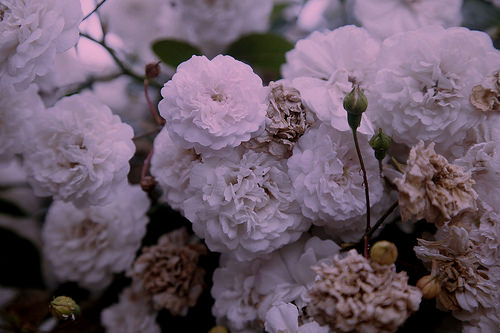

In [9]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[0]))

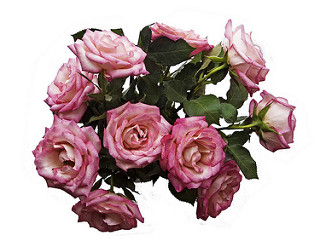

In [10]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[1]))

---
---
---
---

In [11]:
roses[:3]

[PosixPath('/root/.keras/datasets/flower_photos/roses/16078501836_3ac067e18a.jpg'),
 PosixPath('/root/.keras/datasets/flower_photos/roses/4242976586_607a8f9843_n.jpg'),
 PosixPath('/root/.keras/datasets/flower_photos/roses/3264570182_c7ded528ba_m.jpg')]

In [12]:
roses[0]

PosixPath('/root/.keras/datasets/flower_photos/roses/16078501836_3ac067e18a.jpg')

In [13]:
str(roses[0])

'/root/.keras/datasets/flower_photos/roses/16078501836_3ac067e18a.jpg'

---
---
------
---

## Load data using a Keras utility

Let's load these images off disk using the helpful `tf.keras.utils.image_dataset_from_directory` utility.

### Create a dataset

Define some parameters for the loader:

In [14]:
batch_size = 32
img_height = 180
img_width = 180

It's good practice to use a validation split when developing your model. You will use 80% of the images for training and 20% for validation.

In [15]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [16]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


---
---
---
---

In [18]:
data_dir

PosixPath('/root/.keras/datasets/flower_photos')

> - `tf.keras.utils.image_dataset_from_directory()`  
> : Then calling image_dataset_from_directory(main_directory, labels='inferred') will return a tf.data.Dataset that yields batches of images from the subdirectories class_a and class_b, together with labels 0 and 1 (0 corresponding to class_a and 1 corresponding to class_b).
>
> - 결론적으로 `main_directory`에는 `sub_directory`를 가지는 `main_directory` 디렉토리명을 넣어주는 것이고, `labels='inferred'`로 되어 있으면 알아서 클래스를 나눠준다.
> - 그리고 `validatoin_split=`값을 넣어주면 `subset`에 `training` 혹은 `validation`을 넣을 수 있고 이에 따라 training data 혹은 validation data로 return 해주는 것 같다.

In [21]:
temp_val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.4,
    subset='validation',
    seed=0,
)

Found 3670 files belonging to 5 classes.
Using 1468 files for validation.


---
---
---
---

You can find the class names in the `class_names` attribute on these datasets.

In [22]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


### Visualize the data

Here are the first nine images from the training dataset.

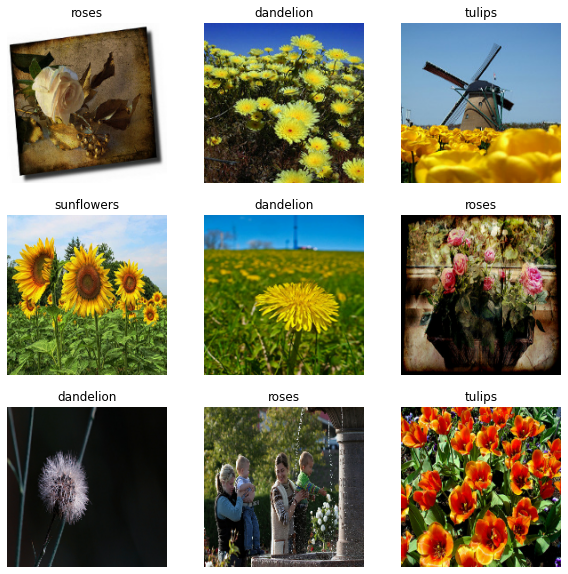

In [23]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_names[labels[i]])
        plt.axis('off')
        


---
---
---
---

In [25]:
images.shape

TensorShape([32, 180, 180, 3])

In [27]:
images[0].shape

TensorShape([180, 180, 3])

> - train_ds.take(1)는 달랑 1개의 데이터만 전달해주는 게 아니라, 일단은 배치사이즈만큼 반환해준다.
> - 그리고 거기서 다시 indexing을 통해 1개만 선택 가능하다.
> - 그리고 이 모든 반환 값은 tensor 자료형이다.

---
---
---
---

You can train a model using these datasets by passing them to `model.fit` (shown later in this tutorial). If you like, you can also manually iterate over the dataset and retrieve batches of images:

In [28]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

You can call `.numpy()` on either of these tensors to convert them to a `numpy.ndarray`.

### Standardize the data


The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network; in general you should seek to make your input values small.

Here, you will standardize values to be in the `[0, 1]` range by using `tf.keras.layers.Rescaling`:

In [29]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

There are two ways to use this layer. You can apply it to the dataset by calling `Dataset.map`:

In [30]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 0.96902645


In [31]:
normalization_layer

In [33]:
test_normalisation_layer = tf.keras.layers.Rescaling(1/10)
test_normalised_ds = train_ds.map(lambda x, y: (test_normalisation_layer(x), y)) # 여기서 하나의 세트(튜플) 형태로 다시 train_ds에 넣어주는 것 같다.(unpacking -> packing?)
temp_img_batch, temp_label_batch = next(iter(test_normalised_ds))
temp_first = temp_img_batch[0]

print(np.min(temp_first), np.max(temp_first))

0.0 25.40787


Or, you can include the layer inside your model definition to simplify deployment. You will use the second approach here.

Note: If you would like to scale pixel values to `[-1,1]` you can instead write `tf.keras.layers.Rescaling(1./127.5, offset=-1)`

Note: You previously resized images using the `image_size` argument of `tf.keras.utils.image_dataset_from_directory`. If you want to include the resizing logic in your model as well, you can use the `tf.keras.layers.Resizing` layer.

### Configure the dataset for performance

Let's make sure to use buffered prefetching so you can yield data from disk without having I/O become blocking. These are two important methods you should use when loading data:

- `Dataset.cache` keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.
- `Dataset.prefetch` overlaps data preprocessing and model execution while training.

Interested readers can learn more about both methods, as well as how to cache data to disk in the *Prefetching* section of the [Better performance with the tf.data API](../../guide/data_performance.ipynb) guide.

In [34]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

---
---
---
---

In [35]:
AUTOTUNE

-1

In [36]:
tf.data.AUTOTUNE

-1

In [37]:
type(AUTOTUNE)

int

> - AUTOTUNE은 int 값을 반환해준다...
> - AUTOTUNE의 사용과 `Dataset.cache()`, `Dataset.prefetch()`의 사용법은 guide 부분에서 다시 한 번 봐야겠다.

---
---
---
---

### Train a model

For completeness, you will show how to train a simple model using the datasets you have just prepared.

The [Sequential](https://www.tensorflow.org/guide/keras/sequential_model) model consists of three convolution blocks (`tf.keras.layers.Conv2D`) with a max pooling layer (`tf.keras.layers.MaxPooling2D`) in each of them. There's a fully-connected layer (`tf.keras.layers.Dense`) with 128 units on top of it that is activated by a ReLU activation function (`'relu'`). This model has not been tuned in any way—the goal is to show you the mechanics using the datasets you just created. To learn more about image classification, visit the [Image classification](../images/classification.ipynb) tutorial.

In [38]:
num_classes = 5

model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255), # Rescaling layer를 처음에 넣은 것을 볼 수 있다.
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

Choose the `tf.keras.optimizers.Adam` optimizer and `tf.keras.losses.SparseCategoricalCrossentropy` loss function. To view training and validation accuracy for each training epoch, pass the `metrics` argument to `Model.compile`.

In [39]:
model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True), # 마지막에 softmax 함수를 거치지 않아서 from_logits=True 값을 넣어준다.
  metrics=['accuracy'])

Note: You will only train for a few epochs so this tutorial runs quickly. 

In [40]:
model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=3
)

Epoch 1/3
92/92 [==============================] - 20s 94ms/step - loss: 1.2532 - accuracy: 0.4653 - val_loss: 1.0834 - val_accuracy: 0.5722
Epoch 2/3
92/92 [==============================] - 5s 52ms/step - loss: 0.9899 - accuracy: 0.6104 - val_loss: 0.9865 - val_accuracy: 0.6226
Epoch 3/3
92/92 [==============================] - 5s 52ms/step - loss: 0.8142 - accuracy: 0.6866 - val_loss: 0.8868 - val_accuracy: 0.6662


Note: You can also write a custom training loop instead of using `Model.fit`. To learn more, visit the [Writing a training loop from scratch](https://www.tensorflow.org/guide/keras/writing_a_training_loop_from_scratch) tutorial.

You may notice the validation accuracy is low compared to the training accuracy, indicating your model is overfitting. You can learn more about overfitting and how to reduce it in this [tutorial](https://www.tensorflow.org/tutorials/keras/overfit_and_underfit).

## Using tf.data for finer control

The above Keras preprocessing utility—`tf.keras.utils.image_dataset_from_directory`—is a convenient way to create a `tf.data.Dataset` from a directory of images.

For finer grain control, you can write your own input pipeline using `tf.data`. This section shows how to do just that, beginning with the file paths from the TGZ file you downloaded earlier.

In [41]:
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'), shuffle=False)
list_ds = list_ds.shuffle(image_count, reshuffle_each_iteration=False)

In [42]:
for f in list_ds.take(5):
  print(f.numpy())

b'/root/.keras/datasets/flower_photos/dandelion/19440910519_cb1162470e.jpg'
b'/root/.keras/datasets/flower_photos/daisy/10466558316_a7198b87e2.jpg'
b'/root/.keras/datasets/flower_photos/tulips/14068295074_cd8b85bffa.jpg'
b'/root/.keras/datasets/flower_photos/sunflowers/14955545254_324cd4ee75.jpg'
b'/root/.keras/datasets/flower_photos/dandelion/4589787911_851cb80157_n.jpg'


---
---
---
---

> - `dataset = tf.data.Dataset.list_files("/path/*.txt")`  
> : To create a dataset of all files matching a pattern, use tf.data.Dataset.list_files:

In [43]:
str(data_dir/'*/*')

'/root/.keras/datasets/flower_photos/*/*'

In [44]:
tf.data.Dataset.list_files(str(data_dir/'*/*'), shuffle=False)

<TensorSliceDataset element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>

In [45]:
tf.data.Dataset.list_files(str(data_dir/'*/*'), shuffle=False).element_spec

TensorSpec(shape=(), dtype=tf.string, name=None)

In [46]:
temp_list = tf.data.Dataset.list_files(str(data_dir/'*/*'), shuffle=False)
for idx, ob in enumerate(temp_list):
    print(ob)
    print(type(ob))
    if idx == 2:
        break

tf.Tensor(b'/root/.keras/datasets/flower_photos/daisy/100080576_f52e8ee070_n.jpg', shape=(), dtype=string)
<class 'tensorflow.python.framework.ops.EagerTensor'>
tf.Tensor(b'/root/.keras/datasets/flower_photos/daisy/10140303196_b88d3d6cec.jpg', shape=(), dtype=string)
<class 'tensorflow.python.framework.ops.EagerTensor'>
tf.Tensor(b'/root/.keras/datasets/flower_photos/daisy/10172379554_b296050f82_n.jpg', shape=(), dtype=string)
<class 'tensorflow.python.framework.ops.EagerTensor'>


In [47]:
temp_list.take(1)

<TakeDataset element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>

In [52]:
list_ds

<ShuffleDataset element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>

---
---
---
---

The tree structure of the files can be used to compile a `class_names` list.

In [48]:
class_names = np.array(sorted([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"]))
print(class_names)

['daisy' 'dandelion' 'roses' 'sunflowers' 'tulips']


---
---
---
---

In [49]:
data_dir.glob('*')

<generator object Path.glob at 0x7fc7cd88fb50>

---
---
---
---

Split the dataset into training and validation sets:

In [51]:
val_size = int(image_count * 0.2)
train_ds = list_ds.skip(val_size)
val_ds = list_ds.take(val_size)

> - 이전에 `list_ds`는 `Shuffledataset`이다.
> - 다시 생각해보면, `Dataset.list_files()` 를 통해 가져온 파일들을 dataset으로 만들어주고,
> - 그것을 숫자대로 `.skip()`메소드를 통해 `train_ds`와 `val_ds`로 만들어주고 있다.

You can print the length of each dataset as follows:

In [54]:
print(tf.data.experimental.cardinality(train_ds))

tf.Tensor(2936, shape=(), dtype=int64)


In [55]:
print(tf.data.experimental.cardinality(train_ds).numpy())
print(tf.data.experimental.cardinality(val_ds).numpy())

2936
734


Write a short function that converts a file path to an `(img, label)` pair:

In [56]:
def get_label(file_path):
  # Convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  one_hot = parts[-2] == class_names
  # Integer encode the label
  return tf.argmax(one_hot)

---
---
---
---

In [58]:
tf.strings.split(str(data_dir))

<tf.Tensor: shape=(1,), dtype=string, numpy=array([b'/root/.keras/datasets/flower_photos'], dtype=object)>

In [59]:
tf.strings.split(str(data_dir), '/')

<tf.Tensor: shape=(5,), dtype=string, numpy=
array([b'', b'root', b'.keras', b'datasets', b'flower_photos'],
      dtype=object)>

In [60]:
tf.strings.split(str(data_dir), os.path.sep)

<tf.Tensor: shape=(5,), dtype=string, numpy=
array([b'', b'root', b'.keras', b'datasets', b'flower_photos'],
      dtype=object)>

In [61]:
tf.strings.split(str(data_dir), os.path.sep)[-2]

<tf.Tensor: shape=(), dtype=string, numpy=b'datasets'>

In [62]:
tf.strings.split(str(data_dir), os.path.sep)[-2] == class_names

<tf.Tensor: shape=(5,), dtype=bool, numpy=array([False, False, False, False, False])>

In [63]:
tf.argmax(tf.strings.split(str(data_dir), os.path.sep)[-2] == class_names)

<tf.Tensor: shape=(), dtype=int64, numpy=0>

---
---
---
---

In [64]:
def decode_img(img):
  # Convert the compressed string to a 3D uint8 tensor
  img = tf.io.decode_jpeg(img, channels=3)
  # Resize the image to the desired size
  return tf.image.resize(img, [img_height, img_width])

In [66]:
def process_path(file_path):
  label = get_label(file_path)
  # Load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

Use `Dataset.map` to create a dataset of `image, label` pairs:

In [67]:
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
train_ds = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(process_path, num_parallel_calls=AUTOTUNE)

---
---
---
---

> - 현재까지의 `train_ds` 제대로된 img, label 파일 형태가 담긴 tensor가 아니라 그냥 file_path로만 이루어진 데이터였다.
> - 그 데이터셋을 갖고 있는 file_path를 이용해 img, label 조합으로 만들어주고 있다.

---
---
---
---

In [68]:
for image, label in train_ds.take(1):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  1


### Configure dataset for performance

To train a model with this dataset you will want the data:

* To be well shuffled.
* To be batched.
* Batches to be available as soon as possible.

These features can be added using the `tf.data` API. For more details, visit the [Input Pipeline Performance](../../guide/performance/datasets.ipynb) guide.

In [70]:
def configure_for_performance(ds):
  ds = ds.cache()
  ds = ds.shuffle(buffer_size=1000)
  ds = ds.batch(batch_size)
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds

train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)

### Visualize the data

You can visualize this dataset similarly to the one you created previously:

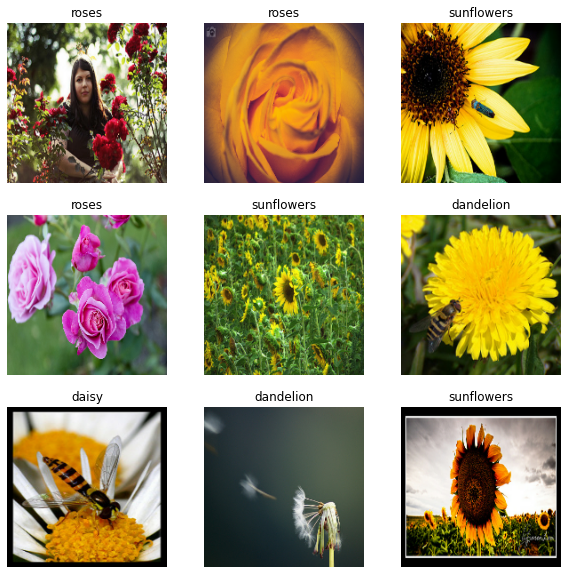

In [71]:
image_batch, label_batch = next(iter(train_ds))

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].numpy().astype("uint8"))
  label = label_batch[i]
  plt.title(class_names[label])
  plt.axis("off")

### Continue training the model

You have now manually built a similar `tf.data.Dataset` to the one created by `tf.keras.utils.image_dataset_from_directory` above. You can continue training the model with it. As before, you will train for just a few epochs to keep the running time short.

In [72]:
model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=3
)

Epoch 1/3
92/92 [==============================] - 12s 105ms/step - loss: 0.6767 - accuracy: 0.7490 - val_loss: 0.5709 - val_accuracy: 0.7793
Epoch 2/3
92/92 [==============================] - 5s 58ms/step - loss: 0.5140 - accuracy: 0.8127 - val_loss: 0.6037 - val_accuracy: 0.7657
Epoch 3/3
92/92 [==============================] - 5s 58ms/step - loss: 0.3214 - accuracy: 0.8913 - val_loss: 0.6740 - val_accuracy: 0.7629


## Using TensorFlow Datasets

So far, this tutorial has focused on loading data off disk. You can also find a dataset to use by exploring the large [catalog](https://www.tensorflow.org/datasets/catalog/overview) of easy-to-download datasets at [TensorFlow Datasets](https://www.tensorflow.org/datasets).

As you have previously loaded the Flowers dataset off disk, let's now import it with TensorFlow Datasets.

Download the Flowers [dataset](https://www.tensorflow.org/datasets/catalog/tf_flowers) using TensorFlow Datasets:

In [73]:
(train_ds, val_ds, test_ds), metadata = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.



Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]


Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


The flowers dataset has five classes:

In [74]:
num_classes = metadata.features['label'].num_classes
print(num_classes)

5


 Retrieve an image from the dataset:

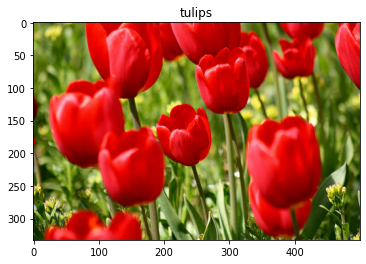

In [75]:
get_label_name = metadata.features['label'].int2str

image, label = next(iter(train_ds))
_ = plt.imshow(image)
_ = plt.title(get_label_name(label))

---
---
---
---

In [76]:
get_label_name

<bound method ClassLabel.int2str of ClassLabel(shape=(), dtype=tf.int64, num_classes=5)>

In [77]:
metadata

tfds.core.DatasetInfo(
    name='tf_flowers',
    version=3.0.1,
    description='A large set of images of flowers',
    homepage='https://www.tensorflow.org/tutorials/load_data/images',
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=5),
    }),
    total_num_examples=3670,
    splits={
        'train': 3670,
    },
    supervised_keys=('image', 'label'),
    citation="""@ONLINE {tfflowers,
    author = "The TensorFlow Team",
    title = "Flowers",
    month = "jan",
    year = "2019",
    url = "http://download.tensorflow.org/example_images/flower_photos.tgz" }""",
    redistribution_info=,
)

In [78]:
metadata.features['label']

ClassLabel(shape=(), dtype=tf.int64, num_classes=5)

In [79]:
label

<tf.Tensor: shape=(), dtype=int64, numpy=2>

In [81]:
metadata.features['label'].int2str(2)

'tulips'

---
---
---
---

As before, remember to batch, shuffle, and configure the training, validation, and test sets for performance:

In [82]:
train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)
test_ds = configure_for_performance(test_ds)

You can find a complete example of working with the Flowers dataset and TensorFlow Datasets by visiting the [Data augmentation](../images/data_augmentation.ipynb) tutorial.

## Next steps

This tutorial showed two ways of loading images off disk. First, you learned how to load and preprocess an image dataset using Keras preprocessing layers and utilities. Next, you learned how to write an input pipeline from scratch using `tf.data`. Finally, you learned how to download a dataset from TensorFlow Datasets.

For your next steps:

- You can learn [how to add data augmentation](https://www.tensorflow.org/tutorials/images/data_augmentation).
- To learn more about `tf.data`, you can visit the [tf.data: Build TensorFlow input pipelines](https://www.tensorflow.org/guide/data) guide.